In [58]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from deg.gradient_extimation import FeatureExtractor
from loss.deg_loss import Loss
from corruption.noise import gaussian, speckle
from Utils.visualize import visualize

In [2]:
Loss.info()

Avalible Loss: ['R2', 'KL Divergence', 'MSE', 'Chi Squared', 'Canberra Distance', 'Jenson Distance', 'AOC']


Text(0.5, 1.0, 'Noisy Lena')

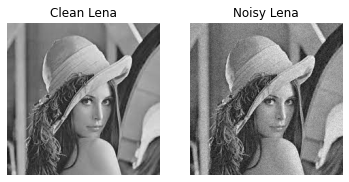

In [50]:
img = cv2.imread("image/lena512.jpg", 0)
img_noise = gaussian(img, 0, 10)

f, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Clean Lena")
ax[1].imshow(img_noise, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Noisy Lena")

In [4]:
backbone = FeatureExtractor(gaussian)
loss = Loss()

img = torch.tensor(img)
img_noise = torch.tensor(img_noise)

p = backbone(img, img_noise)
l = loss(*p)
print(l)

tensor(395.6110)


c:\Users\imsin\Desktop\distortion-estimation-loss\Utils\utils.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.int32)


# Visualize DE-G

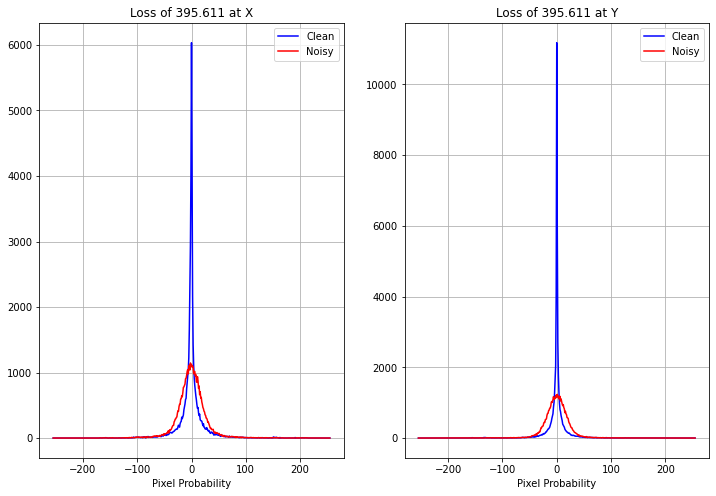

In [5]:
visualize(*p, title="Loss of "+str(round(l.item(),4)))

# Noise Model's Parameter Estimation

In [6]:
from Utils.pso import PSO

### Gaussian Noise

In [7]:
noise_generator = gaussian

In [13]:
mean = 0
var = 5
actual_parameters = [mean, var]
img_query = noise_generator(img, *actual_parameters)

In [9]:
def cost(*params):
    img_noise = noise_generator(img, *params)
    p = backbone(img_query, img_noise)
    return loss(*p)

In [11]:
init_parameters = [0, 10]
bounds = [[0,0], 
          [0.0, 30.0]]
num_particle = 100
epoch = 100

pso = PSO(cost, init_parameters, bounds, num_particle)
res = pso.train(epoch)

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [14]:
print("Results")
print("Actual Parameters:", actual_parameters)
print("Predicted Parameters:", res[0])
print("Loss:", res[1])

Results
Actual Parameters: [0, 5]
Predicted Parameters: [0, 5.083095833929652]
Loss: 321.6690368652344


### Speckle Noise

In [59]:
noise_generator2 = speckle
weight = 0.3
actual_parameters = [weight]
img_query = noise_generator2(img, *actual_parameters)

In [60]:
def cost2(*params):
    img_noise = noise_generator2(img, *params)
    p = backbone(img_query, img_noise)
    return loss(*p)

In [61]:
init_parameters = [0.5]
bounds = [[0.0, 1.0]]
num_particle = 100
epoch = 100

pso2 = PSO(cost2, init_parameters, bounds, num_particle)
res = pso2.train(epoch)

100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


In [63]:
print("Results")
print("Actual Parameters:", actual_parameters)
print("Predicted Parameters:", res[0])
print("Loss:", res[1])

Results
Actual Parameters: [0.3]
Predicted Parameters: [0.3150196651183443]
Loss: 157.54261779785156


# Optimal Parameters Estimation

In [36]:
from skimage.metrics import structural_similarity as ssim
import bm3d
from tqdm import tqdm

In [37]:
def ssim_loss(img1, img2):
    return 1 - ssim(img1, img2)

def deg_loss(img1, img2):
    p = backbone(img1, img2)
    return loss(*p)

In [103]:
img_clean = cv2.imread('image/lena512.jpg', 0)
img_noisy = noise_generator(img_clean, 0, 30)

w_range = np.linspace(0.001, 30, 100)

ssim_l = []
deg_l = []
for std in tqdm(w_range):
    img_restored = bm3d.bm3d(img_noisy.copy(), sigma_psd=std, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    ssim_l.append(ssim_loss(img_clean, img_restored))
    deg_l.append(deg_loss(img_clean, img_restored))

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-37-f91798a09907>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return 1 - ssim(img1, img2)
100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


In [120]:
ssim_predicted = w_range[np.argmin(ssim_l)]
deg_predicted= w_range[np.argmin(deg_l)]

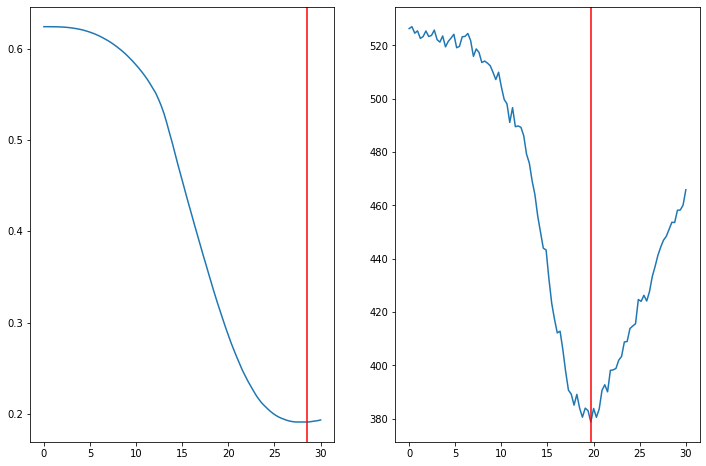

In [121]:
f, ax = plt.subplots(1,2, figsize=(12, 8))
ax[0].plot(w_range, ssim_l)
ax[0].axvline(ssim_predicted, color='r')
ax[1].plot(w_range, deg_l)
ax[1].axvline(deg_predicted, color='r')

In [122]:
img_ssim_optimized = bm3d.bm3d(img_noisy.copy(), sigma_psd=ssim_predicted, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
img_deg_optimized = bm3d.bm3d(img_noisy.copy(), sigma_psd=deg_predicted, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

Text(0.5, 1.0, 'Denoised DEG Optimized')

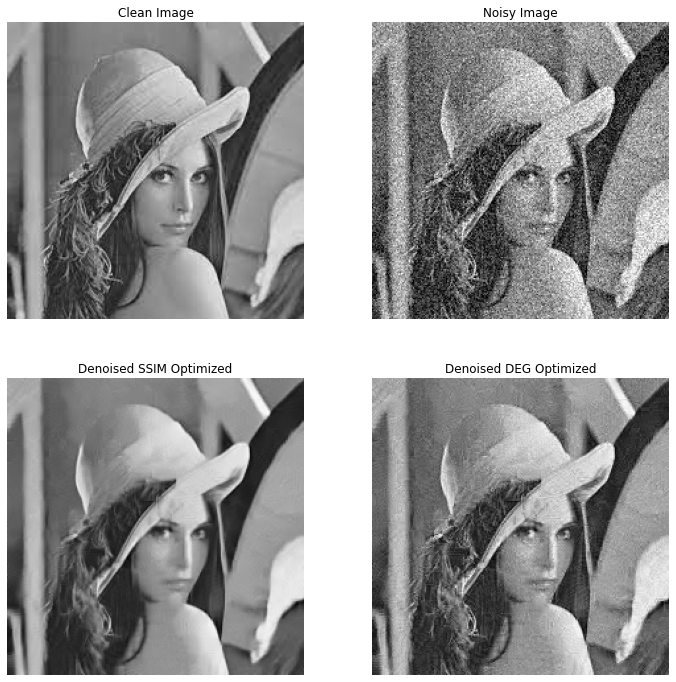

In [124]:
f, ax = plt.subplots(2,2, figsize=(12, 12))
ax[0, 0].imshow(img_clean, cmap='gray')
ax[0, 0].set_axis_off()
ax[0, 0].set_title("Clean Image")
ax[0, 1].imshow(img_noisy, cmap='gray')
ax[0, 1].set_axis_off()
ax[0, 1].set_title("Noisy Image")
ax[1, 0].imshow(img_ssim_optimized, cmap='gray')
ax[1, 0].set_axis_off()
ax[1, 0].set_title("Denoised SSIM Optimized")
ax[1, 1].imshow(img_deg_optimized, cmap='gray')
ax[1, 1].set_axis_off()
ax[1, 1].set_title("Denoised DEG Optimized")